# Desafío 1


José Miguel Quezada Silva  
201773528-7

## Supuestos

- Animales se encuentran en una grilla rectangular de movimiento cíclico

- Conejos comen pasto
    - proporción de pasto en el mapa a partir de un parámetro
    - es infinito (no crece)

- Zorros comen conejos
    - cuando pasan un límite de hambre y hasta que lo alcancen
    - que estén en las posiciones vecinas (distancia de 1 por coordenada)

- Los animales se reproducen 
    - en toda iteración
    - automáticamente, basado en una probabilidad específica para cada especie (no necesitan encontrarse)

- Los animales tienen edades de muerte natural, definidas para cada especie

- En cada iteración, se recorren todas las instancias de animales vivos, en las que ocurre
    - muerte
    - caza
    - reproducción
    - movimiento

- Cada iteración corresponde aproximadamente a una semana

In [20]:
import numpy as np
import time
import sys
import signal
from matplotlib import pyplot as plt
import scipy.linalg as spla
from scipy import integrate
from colorama import init, Back, Fore, Style

# colorama init
init(convert=True)

In [2]:
# imprimir iteraciones y mapa
debug = False
debugMap = False

In [34]:
# dimensiones de mapa
mapDim = 50
mapDimY = mapDim # se puede cambiar para que sea rectangular
# variación de tiempo por iteración
tick = 1

# cantidad máxima de iteraciones
maxT = 140

# cantidad de pasto
probPasto = 0.75
# poblaciones (máximo c/u: 2^15-1 (por uso de int16))
pobZorros = 140
pobConejos = 400

# probabilidad de reproducción
probRepZorros = 0.175
probRepConejos = 0.42
# cuánta hambre reduce la caza
carneConejo = 0.2
# hambre necesaria para empezar a cazar
hambreCazar = 0.6
# muerte por hambre
hambreLimite = 1.2
# edad de muerte natural
edadLimiteZorros = 100
edadLimiteConejos = 80

# probabilidad de caza (casi absoluta)
probCaza = 0.99

# edad mínima para reproducirse
# minEdadRepZorros = 40
# minEdadRepConejos = 20
# tiempo mínimo para reproducirse
# minTSinRepZorros = 25
# minTSinRepConejos = 18

# ocupación máxima del mapa
maxOcupacion = 0.85

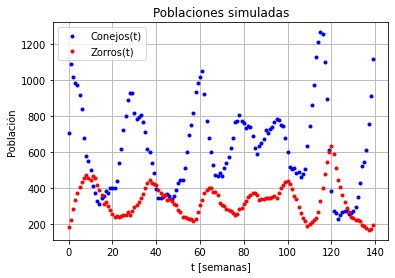

alpha: 0.387828836702192
gamma: 0.0011731266222596043
epsilon: 0.15675807935061561
delta: 0.00026577148712647846


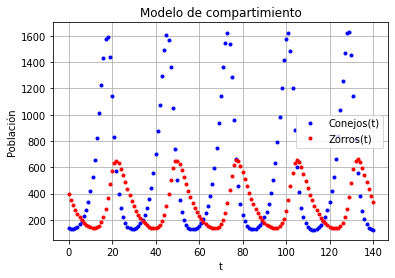

In [35]:
main()

In [4]:
class Animal:

    def __init__(self):
        self.tipo = 0 # zorro = 0 | conejo = 1
        self.hambre = 0
        self.posicion = [0,0]
#         self.sexo = np.random.randint(0, 2) # macho = 0 | hembra = 1
        self.edad = 0
#         self.TSinRep = 0 # tiempo sin reproducirse

    # mov es una int list con coordenadas x,y
    def movimiento(self, mov, xMax, yMax):
        # verifica si llega al límite del mapa, para volver al inicio (como pacman)
        self.posicion[0], self.posicion[1] = vecinoBorde(self.posicion, mov, xMax, yMax)


# es necesario para mantener registro de qué posiciones están siendo ocupadas de manera eficiente
# matriz 2d con arreglos de uint16 (2 byte c/u) [pasto, ocupado, animal, identificador (index)]
class Mapa():
    
    vecindario = [[-1, 1], [0, 1], [1, 1],
                  [-1, 0],         [1, 0], 
                  [-1,-1], [0,-1], [1,-1] ]
    
    # xMax, yMax: límites del mapa
    def __init__(self, xMax, yMax):
        self.xMax = xMax
        self.yMax = yMax

        # dimensiones mínimas de mapa
        if xMax <= 2:
            self.xMax = 3
        if yMax <= 2:
            self.yMax = 3
    
        # np.array de 2 dimensiones de arreglos de int16 ([pasto, ocupado, animal, id])
        self.coord = np.zeros((self.xMax, self.yMax, 4), np.int16)

        #Pasto :D
        i = 0
        for col in self.coord:
            j = 0
            for _ in col:
                self.coord[i][j][0] = np.random.choice([0,1], p=[1 - probPasto, probPasto])
                j += 1
            i += 1


    # pos: int list con coordenadas x,y
    def disponible(self, pos):
        return self.coord[pos[0]][pos[1]][1] == 0

In [5]:
# inicializa posición inicial
def posInicial(mapa):

    initPos = [np.random.randint(0, mapa.xMax), np.random.randint(0, mapa.yMax)]
    
    # busca hasta encontrar una coordenada desocupada
    while not mapa.disponible(initPos):
        initPos = [np.random.randint(0, mapa.xMax), np.random.randint(0, mapa.yMax)]

    return initPos

In [6]:
# inicializar animal, modificando arreglo de su raza y el mapa
# tipoAnimal: zorro: 0 | conejo = 1
def inicializarAnimal(Animales, tipoAnimal, mapa, index):

    Animales.append(Animal())
    Animales[index].tipo = tipoAnimal

    Animales[index].posicion = posInicial(mapa) #cuando se llega a una posición inicial disponible
    mapa.coord[Animales[index].posicion[0]] [Animales[index].posicion[1]] [1] = 1
    mapa.coord[Animales[index].posicion[0]] [Animales[index].posicion[1]] [2] = tipoAnimal
    mapa.coord[Animales[index].posicion[0]] [Animales[index].posicion[1]] [3] = index

    return Animales, mapa

In [7]:
# a partir de un movimiento se retorna la posición correcta
# útil cuando posición actual está en un borde
def vecinoBorde(posActual, vecino, xMax, yMax):
    
    # coordenadas finales
    Xmov = posActual[0] + vecino[0]
    Ymov = posActual[1] + vecino[1]

    # en X
    if Xmov < xMax and Xmov >= 0:
        check_X = Xmov
    elif Xmov < 0:
        check_X = xMax - 1
    else:
        check_X = 0

    # en Y
    if Ymov < yMax and Ymov >= 0:
        check_Y = Ymov
    elif Ymov < 0:
        check_Y = yMax - 1
    else:
        check_Y = 0

    return check_X, check_Y

In [8]:
# define movimiento (random por el momento)
def defMov(mapa, Animal):

    movFactibles = []

    for v in mapa.vecindario:

        check_X, check_Y = vecinoBorde(Animal.posicion, v, mapa.xMax, mapa.yMax)

        # verifica las coordenadas vecinas, y agrega las disponibles como factibles
        if mapa.disponible([check_X, check_Y]):
            movFactibles.append(v)
    
    if Animal.hambre < hambreCazar:
        # posibilidad que se queden quietos, si es que no deben buscar comida
        movFactibles.append([0,0])

    n = len(movFactibles)
    
    #si está rodeado de otros animales
    if n <= 1:
        return [0,0]

    # disminuir probabilidad de quedarse quietos
    prob = 1/n
    probList = [prob + prob/(2*(n - 1)) for _ in range(n)]
    probList[-1] = prob/2
    
    mov_index = np.random.choice(range(n), p = probList)

    return movFactibles[mov_index]

In [9]:
# actualizar mapa, liberando una coordenada
# pos: lista con coordenada [x, y]
def liberarCoord(mapa, pos):

    mapa.coord[pos[0]] [pos[1]] [1] =  0
    mapa.coord[pos[0]] [pos[1]] [2] = -1
    mapa.coord[pos[0]] [pos[1]] [3] = 2**15 - 2 # máximo representable por int16

    return mapa

In [10]:
# elimina un elemento de un arreglo de manera eficiente
# además elimina los datos del elemento del mapa
def swapop(Animales, index, mapa):
   
    coordMapaDead = Animales[index].posicion
    coordMapaLast = Animales[-1].posicion

    # si el elemento a ser eliminado no es el último
    if index < (len(Animales) - 1) and index != -1 and index >= 0:

        # guardar en aux datos del animal muerto
        aux = Animales[index]
        Animales[index] = Animales[-1]
        Animales[-1] = aux
    
    elif index < 0:
        print("\n[swapop]: error: index menor a 0")

    # entregarle posición correcta al animal desplazado
    Animales[index].posicion = coordMapaLast
    mapa.coord[coordMapaLast[0]] [coordMapaLast[1]] [3] = index
    
    # eliminar datos del mapa
    mapa = liberarCoord(mapa, coordMapaDead)
    # eliminar último elemento de arreglo
    Animales.pop()


    return Animales, mapa

In [11]:
#change: coordenada de movimiento actualizado
def verMapa(mapa, change = [-10,-10]):

    i = 0
    for m in mapa.coord:
        # print(i, ":", end=" ")
        print(f"{i:02d}:", end=" ")
        j = 0
        for n in m:
            
            if n[1] == 0 and n[0] == 1:
                data = Fore.GREEN + '^' + Style.RESET_ALL
            elif n[1] == 1 and n[2] == 0:
                data = Fore.RED + "z" + Style.RESET_ALL
            elif n[1] == 1 and n[2] == 1:
                data = "c"
            else:
                data = " "

            if [i,j] == change:
                print(Back.GREEN + data + Style.RESET_ALL, end = "")
            else:
                print(data, end = "")

            j += 1
        print("")
        i += 1
    print("")

In [25]:
# graficar población histórica de cada especie
def graficarPobs(histZorros, histConejos):

    tick_count = len(histZorros) - 1
    x = np.linspace(0, tick_count, tick_count + 1)
    
    plt.figure()
    plt.title("Poblaciones simuladas")
    plt.plot(x, histConejos, 'b.', label='Conejos(t)')
    plt.plot(x, histZorros, 'r.', label='Zorros(t)')
    plt.legend(loc='best')
    plt.xlabel('t [semanas]')
    plt.ylabel('Población')
    plt.grid(True)
    plt.show()

In [14]:
# función derivada (Lotka-Volterra) 
def d_y(t, y, etha, gamma, epsilon, delta):
    y1 = y[0]
    y2 = y[1]
    return np.array([etha * y1 - gamma * y2 * y1, (-epsilon * y2) + delta * y1 * y2])

In [15]:
# obtener constantes de modelo de compartimiento
def obtenerConstantes(tick_count, histZorros, histConejos):
    
    Datas = np.ndarray([2*(tick_count-5),5])

    i = 0
    for t in range(1, tick_count-5):
        y1_prev = histConejos[t-1]  #y1(t)
        y2_prev = histZorros[t-1]   #y2(t)
        y1 = histConejos[t]         #y1(t+1)
        y2 = histZorros[t]          #y2(t+1)

        Datas[t + i - 1] = [y1, -y2*y1,   0,     0,  y1 - y1_prev]
        Datas[t + i]     = [ 0,      0, -y2, y1*y2,  y2 - y2_prev]

        i += 1

    return create_model(Datas)

In [13]:
# graficar modelo de compartimiento
def grafCompartimiento(ctes, tick_count):
        
    etha, gamma, epsilon, delta = ctes
    
    x = np.linspace(0, tick_count, tick_count + 1)
    
    # valores iniciales
    y0 = np.array([pobZorros, pobConejos])
    
    sol = integrate.solve_ivp(d_y, [0,tick_count], y0, t_eval=x, args=(etha, gamma, epsilon, delta))
    
    # por si acaso
    ylen = len(sol.y[0])
    
    plt.figure()
    plt.title("Modelo de compartimiento")
    plt.plot(x[0:ylen], sol.y[0], 'b.', label='Conejos(t)')
    plt.plot(x[0:ylen], sol.y[1], 'r.', label='Zorros(t)')
    plt.legend(loc='best')
    plt.xlabel('t [semanas]')
    plt.ylabel('Población')
    plt.grid(True)
    plt.show()

In [16]:
# factorizar matriz A en Q y R
def QR(A, type_factorization = 'reduced', type_gram_schmidt='classic'):
    A.astype('float')
    m,n = A.shape # m: number of rows, n: number of columns.
    if type_factorization == 'reduced':
        Q = np.zeros((m,n))
        R = np.zeros((n,n))
    elif type_factorization == 'full':
        Q = np.zeros((m,m))
        R = np.zeros((m,n))
    for k in range(n):
        y = A[:,k]
        for i in range(k):
            if type_gram_schmidt == 'classic':
                R[i,k] = np.dot(Q[:,i],A[:,k])
            elif type_gram_schmidt == 'modified':
                R[i,k] = np.dot(Q[:,i],y)
            y=y-R[i,k]*Q[:,i]
        R[k,k] = np.linalg.norm(y)
        Q[:,k] = y/np.linalg.norm(R[k,k])
    return Q,R
    
# resolver mínimos cuadrados a partir de factorización QR
def least_squares(A,b):
    Q,R = QR(A,type_gram_schmidt='modified')
    return spla.solve_triangular(R,np.dot(Q.T,b))

# se genera una matriz A a partir de las poblaciones históricas
# para resolver el sistema Ax = b, con b las derivadas y x las constantes del modelo de compartimiento
def create_model(data):
    A = np.ones((data.shape[0],4))
    A[:,0] = data[:,0]
    A[:,1] = data[:,1]
    A[:,2] = data[:,2]
    A[:,3] = data[:,3]
    b = data[:,4] #dY
    
    M = {'A':A,
         'b':b}
         
    return least_squares(M['A'], M['b']) 

In [33]:
# función a ejecutar al terminar la simulación
def modelEnd(tick_count, histZorros, histConejos):
    
    graficarPobs(histZorros, histConejos)
    
    ctes = obtenerConstantes(tick_count, histZorros, histConejos)
    print("alpha:", ctes[0])
    print("gamma:", ctes[1])
    print("epsilon:", ctes[2])
    print("delta:", ctes[3])
    
    grafCompartimiento(ctes, tick_count)

In [32]:
def main():

    # manejar ctrl + C
    def signal_handler(sig, frame):
        modelEnd(tick_count, histZorros, histConejos)
        sys.exit(0)
        
    signal.signal(signal.SIGINT, signal_handler)


# - INICIALIZACIÓN -

    mapa = Mapa(mapDim, mapDimY)

    #arreglos de animales, listas enlazadas de animales, diccionarios de animales?
    Zorros = []
    Conejos = []

    i = 0
    while i < pobZorros:
        Zorros, mapa = inicializarAnimal(Zorros, 0, mapa, i)
        Zorros[i].hambre = hambreCazar / 4
        i += 1

    i = 0
    while i < pobConejos:
        Conejos, mapa = inicializarAnimal(Conejos, 1, mapa, i)
        i += 1


# - ITERACIONES -

    # poblaciones en cada iteracióm
    pobZorrosAct = pobZorros
    pobConejosAct = pobConejos
    ocupacionActual = (pobZorros + pobConejos) / (mapDim * mapDimY)
    casaSola = True # controla la reproducción
    
    tick_count = 0
    
    # registros de población (para graficar)
    histZorros = []
    histConejos = []
    
    while(tick_count < maxT and pobZorrosAct > 5 and pobConejosAct > 5 ):

        # os.system('cls' if os.name == 'nt' else 'clear')  # Para que se refresque la terminal
        if debugMap:
            print("\nMAPA", tick_count)
            verMapa(mapa)
        if debug:
            print("Zorros:", pobZorrosAct, end="\t|\t")
            print("Conejos:", pobConejosAct)

        z_index = 0
        zorrosNuevos = 0
        zorrosMuertos = []  #lista de índices
        conejosCazados = [] #lista de índices
        for _ in Zorros:

            # muerte por hambre o edad
            if Zorros[z_index].hambre >= hambreLimite or Zorros[z_index].edad >= edadLimiteZorros:

                zorrosMuertos.append(z_index)
                z_index += 1
                continue
            

            # cazar
            for v in mapa.vecindario:
                if Zorros[z_index].hambre >= hambreCazar:
                    
                    check_X, check_Y = vecinoBorde(Zorros[z_index].posicion, v, mapa.xMax, mapa.yMax)
                    
                    # si es conejo
                    if not mapa.disponible([check_X, check_Y]) and mapa.coord[check_X][check_Y][2] == 1:

                        # matar conejo
                        if (np.random.random() < probCaza):

                            idConejoKill = mapa.coord[check_X][check_Y][3]

                            conejosCazados.append(idConejoKill)

                            # liberar coordenada de presencia animal
                            mapa = liberarCoord(mapa, [check_X, check_Y])

                            Zorros[z_index].hambre -= carneConejo
                else:
                    break


            # reproducción
            if casaSola and (np.random.random() < probRepZorros):
                zorrosNuevos += np.random.randint(1,3)
            '''
            # reproducción, teniendo que encontrarse los animales
            if casaSola:
                for v in mapa.vecindario:
                    if Zorros[z_index].TSinRep >= minTSinRepZorros and Zorros[z_index].edad >= minEdadRepZorros:

                        check_X, check_Y = vecinoBorde(Zorros[z_index].posicion, v, mapa.xMax, mapa.yMax)

                        infoPareja = mapa.coord[check_X][check_Y]

                        # si es zorro y es del sexo opuesto
                        if not mapa.disponible([check_X, check_Y])\
                        and infoPareja[2] == 0:
                        # and Zorros[z_index].sexo != Zorros[infoPareja[3]].sexo:

                            if (np.random.random() < probRepZorros):

                                # cantidad aleatoria de hijos
                                zorrosNuevos += np.random.randint(1,3)

                                Zorros[z_index].TSinRep = 0
                                Zorros[infoPareja[3]].TSinRep = 0
                    else:
                        break
            '''

            # movimiento
            mov = defMov(mapa, Zorros[z_index])
            
            if mov != [0, 0]:
                
                # liberar posición inicial
                mapa = liberarCoord(mapa, Zorros[z_index].posicion)
                
                Zorros[z_index].movimiento(mov, mapa.xMax, mapa.yMax)
                
                # actualizar mapa con nueva posición
                mapa.coord[Zorros[z_index].posicion[0]] [Zorros[z_index].posicion[1]] [1] = 1
                mapa.coord[Zorros[z_index].posicion[0]] [Zorros[z_index].posicion[1]] [2] = 0
                mapa.coord[Zorros[z_index].posicion[0]] [Zorros[z_index].posicion[1]] [3] = z_index
            

            Zorros[z_index].hambre += 0.5
#             Zorros[z_index].TSinRep += 1
            Zorros[z_index].edad += 1
            z_index += 1

        # eliminar zorros muertos de Zorros
        if debug:
            if len(zorrosMuertos) > 0:
                print("zorros muertos:", len(zorrosMuertos))
            else:
                print("")
        
        for zm in reversed(zorrosMuertos):
            Zorros, mapa = swapop(Zorros, zm, mapa)
            pobZorrosAct -= 1
        
        # agregar zorrosNuevos zorros nuevos a Zorros
        if debug:
            if zorrosNuevos > 0:
                print("zorros nuevos:", zorrosNuevos)
            else:
                print("")
        
        for zn in range(zorrosNuevos):
            inicializarAnimal(Zorros, 0, mapa, pobZorrosAct + zn)

        pobZorrosAct += zorrosNuevos

        # eliminar conejos cazados
        if debug:
            if len(conejosCazados) > 0:
                print("conejos cazados:", len(conejosCazados))
            else:
                print("")
        
        for cc in reversed(sorted(conejosCazados)):
            Conejos, mapa = swapop(Conejos, cc, mapa)
            pobConejosAct -= 1
            
        if debug:
            print("- - - - - - - - - - - -")


        c_index = 0
        conejosNuevos = 0
        conejosMuertos = []
        for _ in Conejos:

            # muerte por hambre o edad
            if Conejos[c_index].hambre >= hambreLimite or Conejos[c_index].edad >= edadLimiteConejos:
                
                conejosMuertos.append(c_index)
                c_index += 1
                continue

            
            # comer                             // si la coordenada tiene pasto
            if Conejos[c_index].hambre >= 2 and mapa.coord[Conejos[c_index].posicion[0]] [Conejos[c_index].posicion[1]][0] == 1:
                Conejos[c_index].hambre -= 4
                #pasto crece?


            # reproducción
            if casaSola and (np.random.random() < probRepConejos):
                conejosNuevos += np.random.randint(1,4)

            '''
            # reproducción, teniendo que encontrarse los animales
            if casaSola:
                for v in mapa.vecindario:
                    
                    if Conejos[c_index].TSinRep >= minTSinRepConejos and Conejos[c_index].edad >= minEdadRepConejos:

                        check_X, check_Y = vecinoBorde(Conejos[c_index].posicion, v, mapa.xMax, mapa.yMax)

                        infoPareja = mapa.coord[check_X][check_Y]

                        # si es conejo y es del sexo opuesto
                        if not mapa.disponible([check_X, check_Y]) \
                        and infoPareja[2] == 1:
                        # and Conejos[c_index].sexo != Conejos[infoPareja[3]].sexo:

                            if (np.random.random() < probRepConejos):

                                #generar nuevo conejo (no puedo agregarlo en esta iteración)
                                conejosNuevos += np.random.randint(1,4)
                                Conejos[c_index].TSinRep = 0
                                Conejos[infoPareja[3]].TSinRep = 0
                    
                    else:
                        break
            '''

            # movimiento
            mov = defMov(mapa, Conejos[c_index])
            if mov != [0, 0]:
                
                # liberar posición inicial
                mapa = liberarCoord(mapa, Conejos[c_index].posicion)
                
                #quizás los conejos deberían buscar alejarse de los zorros
                Conejos[c_index].movimiento(mov, mapa.xMax, mapa.yMax)
                
                # actualizar mapa con nueva posición
                mapa.coord[Conejos[c_index].posicion[0]] [Conejos[c_index].posicion[1]] [1] = 1
                mapa.coord[Conejos[c_index].posicion[0]] [Conejos[c_index].posicion[1]] [2] = 1
                mapa.coord[Conejos[c_index].posicion[0]] [Conejos[c_index].posicion[1]] [3] = c_index


            Conejos[c_index].hambre += 1
#             Conejos[c_index].TSinRep += 1
            Conejos[c_index].edad += 1
            c_index += 1
        
        # eliminar conejos muertos de Conejos
        if debug:
            if len(conejosMuertos) > 0:
                print("conejos muertos: ", len(conejosMuertos))
            else:
                print("")
        
        for cm in reversed(conejosMuertos):        
            Conejos, mapa = swapop(Conejos, cm, mapa)
            pobConejosAct -= 1
        
        # agregar conejosNuevos conejos nuevos a Conejos
        if debug:
            if conejosNuevos > 0:
                print("conejos nuevos", conejosNuevos)
            else:
                print("")
            
            print("\n________________________________________________________________________________________\n\n\n")

        
        for cn in range(conejosNuevos):
            inicializarAnimal(Conejos, 1, mapa, pobConejosAct + cn)

        pobConejosAct += conejosNuevos

        # limitar reproducción
        ocupacionActual = (pobZorros + pobConejos) / (mapDim * mapDimY)
        if ocupacionActual >= maxOcupacion:
            casaSola = False
        else:
            casaSola = True


        histZorros.append(pobZorrosAct)
        histConejos.append(pobConejosAct)

        time.sleep(tick)
        tick_count += 1

        print(tick_count, end="\r")

    #graficar
    modelEnd(tick_count, histZorros, histConejos)